In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import utils
import os

import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from sklearn.metrics import mean_absolute_error as mae
import lightgbm as lgb

In [3]:
DATA_DIR = "../../working_data/"
SRC_DATA_DIR = "../../datasets/processed_data/"

In [4]:
class DataBuilder:
    # TODO: функции доступа к date и id, тк сейчас они то в колоноках,
    # то в индексах, так что вылетают рандомные ошибки
    def __init__(self, hydro, meteo, s2m_dict):
        self.hydro = self.prepare_df(hydro)
        self.meteo = self.prepare_df(meteo)
        self.s2m_dict = s2m_dict
        
    def prepare_df(self, df):
        df["date"] = pd.to_datetime(df["date"])
        first2cols = list(df.columns[:2])
        df.set_index(first2cols, inplace=True)
        
        return df
    
    def build(self):
        self.fill_missing_dates()
        self.merged = self.merge_parts()
        self.extract_merged_x_y()
        
        return self.features, self.target
    
    def fill_missing_dates(self):
        min_date, max_date = self.min_max_data_date()
        
        new_hydro_idx = self.create_all_dates_index(self.hydro, min_date, max_date)
        new_meteo_idx = self.create_all_dates_index(self.meteo, min_date, max_date)
        
        fill_val = np.nan
        self.hydro = self.hydro.reindex(new_hydro_idx, fill_value=fill_val)
        self.meteo = self.meteo.reindex(new_meteo_idx, fill_value=fill_val)
    
    def min_max_data_date(self):
        dates_hydro = self.hydro.index.get_level_values("date")
        dates_meteo = self.meteo.index.get_level_values("date")
        
        min_date = min(dates_hydro.min(), dates_meteo.min())
        max_date = max(dates_hydro.max(), dates_meteo.max())
        
        return min_date, max_date
    
    def create_all_dates_index(self, df, min_date, max_date):
        id_idxs = df.index.get_level_values(0).unique()
        new_date_index = pd.date_range(min_date, max_date, name="date")
        
        all_dates_index = pd.MultiIndex.from_product([id_idxs, new_date_index])
        
        return all_dates_index
    
    def merge_parts(self):
        nearest_meteo_id = self.hydro_to_meteo_map_col()
        
        hydro = self.hydro.reset_index()
        meteo = self.meteo

        merged = hydro.merge(meteo, left_on=[nearest_meteo_id, "date"], right_on=["stationNumber", "date"], how="left")
        merged.set_index(["id", "date"], inplace=True)
        
        return merged
    
    def hydro_to_meteo_map_col(self):
        hydro_id = self.hydro.index.get_level_values("id")
        hydro_nearest_meteo = hydro_id.map(self.s2m_dict)
        
        return hydro_nearest_meteo
    
    def extract_merged_x_y(self):
        feature_cols = list(self.merged.columns)
        feature_cols.remove("target")

        self.features = self.merged[feature_cols]
        self.target = self.merged["target"]

In [5]:
hydro = pd.read_csv(DATA_DIR + "hydro_features.csv")
meteo = pd.read_csv(DATA_DIR + "meteo_features.csv")

hydro = utils.reduce_memory_usage(hydro)
meteo = utils.reduce_memory_usage(meteo)

s2m = pd.read_csv(DATA_DIR + "handmade_s2m.csv", index_col=0)
s2m_dict = s2m.to_dict()["meteo_id"]

In [6]:
hydro

,id,date,max_level_nanmean_1_7,max_level_nanmean_1_30,max_level_nanstd_1_30,max_level_nanmax_1_7,max_level_nanmin_1_7,max_level_nanmax_1_30,max_level_nanmin_1_30,max_level_lag_1,...,diff_nanmean,diff_nanstd,doy_lag1,doy_lag2,doy_mean_last_5_years,doy_std_last_5_years,latitude,longitude,doy,target
0,5004,1984-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,47.930000,132.479996,1,112.0
1,5004,1984-01-02,112.000000,112.000000,NaN,112.0,112.0,112.0,112.0,112.0,...,NaN,NaN,NaN,NaN,NaN,NaN,47.930000,132.479996,2,118.0
2,5004,1984-01-03,115.000000,115.000000,4.242640,118.0,112.0,118.0,112.0,118.0,...,6.000000,0.000000,NaN,NaN,NaN,NaN,47.930000,132.479996,3,134.0
3,5004,1984-01-04,121.333336,121.333336,11.372481,134.0,112.0,134.0,112.0,134.0,...,11.000000,5.000000,NaN,NaN,NaN,NaN,47.930000,132.479996,4,149.0
4,5004,1984-01-05,128.250000,128.250000,16.660831,149.0,112.0,149.0,112.0,149.0,...,12.333333,4.496912,NaN,NaN,NaN,NaN,47.930000,132.479996,5,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93963,6027,2020-09-27,572.142883,657.200012,69.164169,621.0,528.0,764.0,528.0,528.0,...,-16.714285,8.497298,426.0,396.0,349.399994,82.964088,49.299999,129.679993,271,526.0
93964,6027,2020-09-28,558.571411,651.033325,72.374733,614.0,526.0,764.0,526.0,526.0,...,-13.571428,9.255997,418.0,378.0,348.600006,80.398010,49.299999,129.679993,272,522.0
93965,6027,2020-09-29,545.428589,645.200012,75.525925,596.0,522.0,764.0,522.0,522.0,...,-13.142858,9.612917,419.0,366.0,347.200012,80.322845,49.299999,129.679993,273,514.0
93966,6027,2020-09-30,533.714294,639.700012,78.911629,564.0,514.0,764.0,514.0,514.0,...,-11.714286,9.527618,411.0,362.0,345.200012,80.462166,49.299999,129.679993,274,514.0


In [7]:
builder = DataBuilder(hydro, meteo, s2m_dict)
features, target = builder.build()

In [8]:
del hydro, meteo, builder

In [9]:
# drop objects where target is none
target_notnan_mask = target.notna()
features, target = features[target_notnan_mask], target[target_notnan_mask]

In [10]:
# class DatasetRetriever(Dataset):
#     def __init__(self, features, target):
#         super().__init__()
#         self.features = features
#         self.target = target
        
#     def __getitem__(self, index: int):
#         obj_features = self.features.iloc[index]
#         obj_target = self.target.iloc[index]
        
#         return obj_features, obj_target
        
#     def __len__(self):
#         return len(self.features)
    
# data_retr = DatasetRetriever(features, target)

### training model for single post

In [11]:
class TimeSeriesValFoldRetriever:
    def __init__(self, features, labels, nfolds=12, val_width=30):
        self.features = features
        self.labels = labels
        
        self.dates = self.features.index.get_level_values("date")
        self.uniq_dates = sorted(self.dates.unique())
        self.unique_dates_num = len(self.uniq_dates)
        
        self.nfolds = nfolds
        self.val_width = val_width
        
        self.set_folds_periods()
        
        
    def set_folds_periods(self):
        self.train_masks = []
        self.val_masks = []
        
        train_start = 0
        last_idx = self.unique_dates_num - 1
        
        for fold_idx in range(self.nfolds):
            folds_till_end = self.nfolds - fold_idx + 1
            train_end = last_idx - folds_till_end * self.val_width
            
            val_start = train_end
            val_end = val_start + self.val_width
            
            train_dates = self.uniq_dates[train_start: train_end]
            val_dates = self.uniq_dates[val_start: val_end]
            
            train_date_mask = self.dates.isin(train_dates)
            val_date_mask = self.dates.isin(val_dates)
            
            self.train_masks.append(train_date_mask)
            self.val_masks.append(val_date_mask)
        
#     def __next__(self):
        
        
        
    def __iter__(self):
        for fold_idx in range(self.nfolds):
            train_period = self.train_masks[fold_idx]
            val_period = self.val_masks[fold_idx]
            
            train_features, train_labels = self.features[train_period], self.labels[train_period]
            val_features, val_labels = self.features[val_period], self.labels[val_period]
            
            yield train_features, train_labels, val_features, val_labels

In [12]:
class LgbModel:
    """Controlles process of training model on data from single station"""
    def __init__(self, model_config):
        self.lgb_param = model_config
            
    def fit(self, x, y):
        dataset = lgb.Dataset(x, y)
        self.model = lgb.train(self.lgb_param, dataset)
        
    def predict(self, features):
        return self.model.predict(features)

In [13]:
class StationModelsManager:
    """creates StattionFitters for every station_id from __init__, 
    Cat train and evaluate these models, return final metric for all stations"""
    def __init__(self, station_ids, model_class, model_config):
        self.station_ids = station_ids
        self.models = {}
        
        for id_stat in self.station_ids:
            model = model_class(model_config) # подавать созданные модели снаружи!!!!!!
            self.models[id_stat] = model
        
    
    def fit(self, features: pd.DataFrame, target: pd.DataFrame):
        
        for station_id, model in self.models.items():
            station_features = self._get_station_data(features, station_id)
            station_target = self._get_station_data(target, station_id)
            model.fit(station_features, station_target)
            
    def predict(self, features: pd.DataFrame):
        answers = np.zeros(len(features))
        
        for station_id, model in self.models.items():
            station_features = self._get_station_data(features, station_id)
            station_model = self.models[station_id]
            preds = station_model.predict(station_features)
            
            curr_station_mask = self._curr_station_mask(features, station_id)
            answers[curr_station_mask] = preds
            
        return answers
            
    def _get_station_data(self, df, station_id):
        station_mask = self._curr_station_mask(df, station_id)
        df_station = df.iloc[station_mask]
        return df_station
    
    def _curr_station_mask(self, df, station_id):
        id_col = df.reset_index()["id"]
#         print("ID", id_col)
#         print("ST", station_id)
        station_mask = (id_col == station_id).values
        
        return station_mask

In [14]:
class CrossValidator:
    def __init__(self, folds, model, metric):
        """
        :param folds: iterable containing t_x, t_y, v_x, v_y"""
        self.folds = folds
        self.model = model
        self.metric = metric
        
    def run_cv(self):
        self.metric_vals = []
        
        for fold_num, (xtrain, ytrain, xval, yval) in enumerate(self.folds):
            print(f"starting {fold_num} fold")
            model.fit(xtrain, ytrain)
            val_preds = model.predict(xval)
            
            metric_val = self.metric(val_preds, yval)
            self.metric_vals.append(metric_val)
            
        return np.mean(self.metric_vals)


In [15]:
target

id    date      
5004  1984-01-01    112.0
      1984-01-02    118.0
      1984-01-03    134.0
      1984-01-04    149.0
      1984-01-05    156.0
                    ...  
6027  2020-09-27    526.0
      2020-09-28    522.0
      2020-09-29    514.0
      2020-09-30    514.0
      2020-10-01    500.0
Name: target, Length: 92753, dtype: float32

In [16]:
target_station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]
target_stations_mask = features.reset_index()["id"].isin(target_station_ids).values

features = features[target_stations_mask]
target = target[target_stations_mask]

In [17]:
lgb_param = {
    "objective": "regression",
    "verbose": -1
}

folds_retriever = TimeSeriesValFoldRetriever(features, target, nfolds=12, val_width=31)
model = StationModelsManager(target_station_ids, LgbModel, lgb_param)

cross_val = CrossValidator(folds_retriever, model, mae)

In [18]:
cross_val.run_cv()

starting 0 fold
starting 1 fold
starting 2 fold
starting 3 fold
starting 4 fold
starting 5 fold
starting 6 fold
starting 7 fold
starting 8 fold
starting 9 fold
starting 10 fold
starting 11 fold


14.656991208517525

In [19]:
cross_val.metric_vals

[12.580538861089774,
 12.567009221379557,
 6.387276714012099,
 6.7060387799033165,
 26.387451529787445,
 38.971159432056716,
 19.07611540059093,
 13.263169818489303,
 10.51596558139633,
 9.734902018563082,
 7.635668598370232,
 12.058598546571481]

In [20]:
np.mean(cross_val.metric_vals)

14.656991208517525

In [23]:
features[["max_level_lag_1", "diff_1"]]
target

max_level_lag_1  diff_1
id   date                               
5004 1984-01-01              NaN     NaN
     1984-01-02            112.0     NaN
     1984-01-03            118.0     6.0
     1984-01-04            134.0    16.0
     1984-01-05            149.0    15.0
...                          ...     ...
6027 2020-09-27            528.0    -8.0
     2020-09-28            526.0    -2.0
     2020-09-29            522.0    -4.0
     2020-09-30            514.0    -8.0
     2020-10-01            514.0     0.0

[92753 rows x 2 columns]

id    date      
5004  1984-01-01    112.0
      1984-01-02    118.0
      1984-01-03    134.0
      1984-01-04    149.0
      1984-01-05    156.0
                    ...  
6027  2020-09-27    526.0
      2020-09-28    522.0
      2020-09-29    514.0
      2020-09-30    514.0
      2020-10-01    500.0
Name: target, Length: 92753, dtype: float32

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

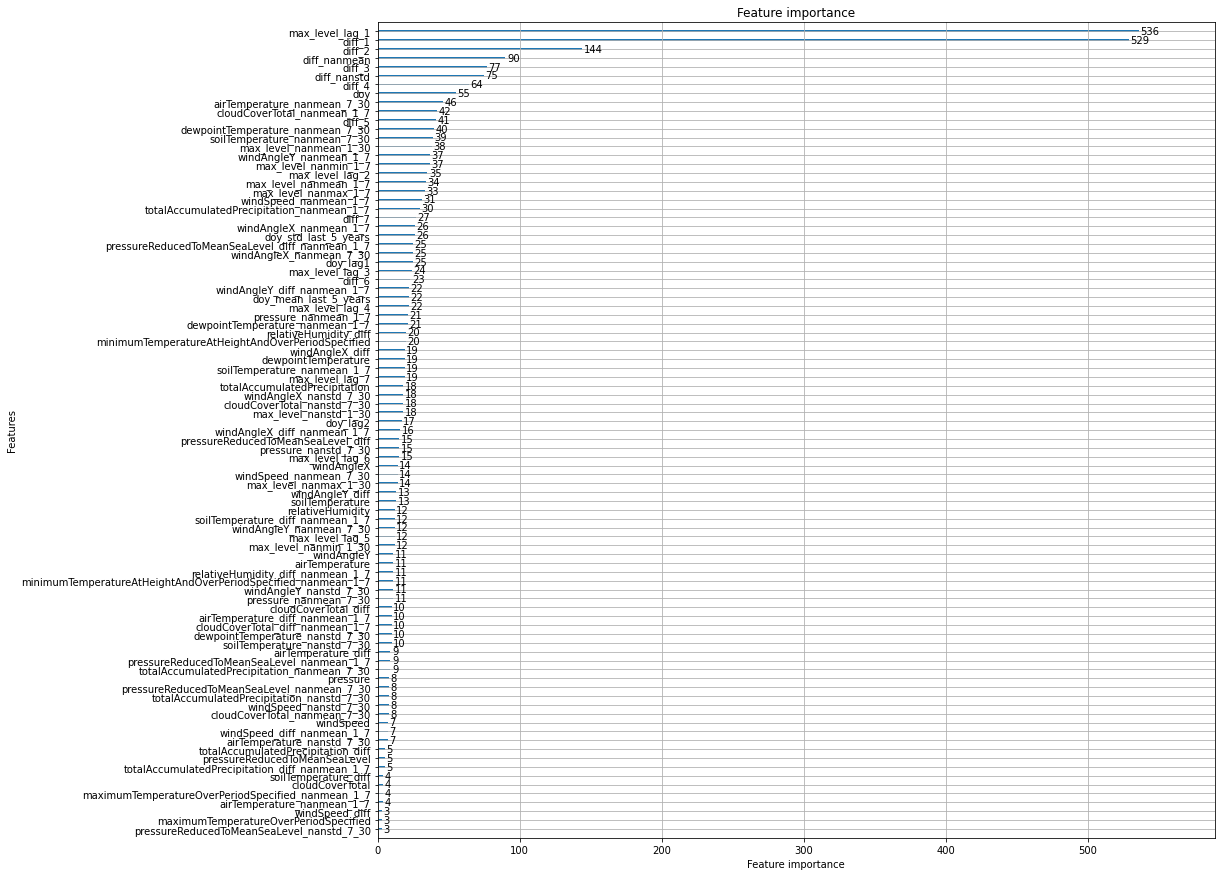

In [21]:
# plt.figure(figsize=(20, 20))
lgb.plot_importance(model.models[5004].model, figsize=(15, 15))